# <b> Entity Embeddings for ML </b>
*Give them a try: they perform better than one-hot encodings.*

# <b> Implementation

In [ ]:
# import modules
import pandas as pd
from fastai.tabular.all import *
from fastcore.utils import *
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## <b> 1. Train a neural network with embeddings


We will use a simple dataset from Kaggle's March Tabular Playground Series. Download the data [here](https://www.kaggle.com/c/tabular-playground-series-mar-2021/data).

In [ ]:
# load Google Drive where the downloaded data is
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# read data
df_nn = pd.read_csv('/content/drive/MyDrive/tabular-playground-series-mar-2021/train.csv', low_memory=False)
df_nn_final = df_nn.drop('id', axis=1)
df_nn.head()
# yhat = pd.read_csv('/content/drive/MyDrive/tabular-playground-series-mar-2021/test.csv', low_memory=False)



,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [ ]:
# define options
cont,cat = cont_cat_split(df_nn_final, max_card=9000, dep_var='target')
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(seed=23)(df_nn_final)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# feed the data into the Learner
to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                      splits=splits, y_names='target')
dls = to_nn.dataloaders(1024, device = device)
learn = tabular_learner(dls, layers=[500,250], n_out=1)

In [ ]:
# train the data
learn.fit_one_cycle(8, 5e-4)

epoch,train_loss,valid_loss,time
0,0.146166,0.126819,00:05
1,0.119647,0.125680,00:03
2,0.114833,0.116169,00:03
3,0.113469,0.114988,00:04
4,0.110665,0.114331,00:03
5,0.108416,0.111277,00:03
6,0.106194,0.110565,00:03
7,0.106042,0.110439,00:03


The end result is a neural network with an embedding layer that can be used to represent each categorical variable. Usually the size of the embeddings is a hyperparameter to be specified, but fast.ai makes this easy by automatically inferring an appropriate embedding size based on the cardinality of the variable.

This step can be done in pure PyTorch or TensorFlow; just make sure to modify the appropriate parts of the subsequent code if you choose to do so.

In [ ]:
# get ROC/AUC score
preds,targs = learn.get_preds()
roc_auc_score(targs, preds)

0.8860170644529568

In [ ]:
# save model
learn.save('learn8')

Path('models/learn8.pth')

## <b> Machine Learning Models

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tabular-playground-series-mar-2021/train.csv', low_memory=False)

In [ ]:
# using the neural networkss `cat`, `cont`, and `splits` value for creating ML model
procs = [Categorify]
to = TabularPandas(df, procs, cat, cont, 'target', splits = splits)

In [ ]:
# defining Random Forest Classifier
def rf(xs, y, n_estimators=40, max_samples=130_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf).fit(xs, y)

In [ ]:
# defining auc metric
def auc(m, xs, y):
  preds = m.predict(xs)
  return round(roc_auc_score(y, preds), 3)

# <b> 2. Replace each categorical value with its embedding vector


In [ ]:
learn = learn.load('/content/models/learn8')

In [ ]:
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables with nominal values defined by their rank.
  ::returns:: a copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
  
    # get matrix containing each row's embedding vector
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64).to(device))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]

    # join the embedded category and drop the old feature column
    feat_df = pd.DataFrame(data=emb_data, index=xs.index, columns=emb_names)
    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs

This function expands each categorical column (a vector of size **n_rows**) into an embedding matrix of shape (**n_rows**, **embedding_dim**). Now we use it to embed the categorical columns of our data.

> Indented block



In [ ]:
emb_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)

In [ ]:
# It is a steep task to follow the code without experimenting with it yourself, so here is the before and after of first 3 values of the dataset:

In [ ]:
# emd_xs.head(3)

In [ ]:
# emb_valid_xs.head(3)

In [ ]:
save_pickle('/content/emb_xs', emb_xs)
save_pickle('/content/emb_valid_xs', emb_valid_xs)

I index into a subset of the data to speed up the experimental evaluation (to determine if the entity embeddings are working).

In [ ]:
m_cat = rf(to.train.xs.iloc[:50_000], to.train.y.iloc[:50_000], max_samples=25_000)
auc(m_cat, to.train.xs, to.train.y), auc(m_cat, to.valid.xs, to.valid.y)

(0.777, 0.765)

In [ ]:
# this cell will take a minute
m_emb = rf(emb_xs.iloc[:50_000], to.train.y.iloc[:50_000], max_samples=25_000)
auc(m_emb, emb_xs, to.train.y), auc(m_emb, emb_valid_xs, to.valid.y)

(0.781, 0.767)

The results above indicate the performance improvement we get from replacing categorical variables with more informative entity embeddings. Entity embeddings perform best when representing inherently continuous features with high cardinality, but you should see a modest boost in performance in any data (given no change in hyperparameters; if we tune the hyperparameters, the performance will further increase).

You might have noticed that the model training on the entity embeddings took longer. My article [Entity Embeddings for ML](https://towardsdatasciencecomentity-embeddings-for-ml-2387eb68e49#34da-7ef1c93bb9cd) explains why this is so under the `Feature selection` section. For here, though, we'll jump to a solution to that problem: selecting the most salient features and only using those.

# <b> 3. Train ML algorithms on the embedded data



Most of the heavy lifting has already been done; we can now train our machine learning algorithm in the standard way, but passing the embedded data as input.

Here’s an example of a pipeline for training a random forest:

In [ ]:
# this might take a while
random = RandomForestClassifier(n_estimators=40, max_samples=100_000,      
                          max_features=.5, min_samples_leaf=5)
random = random.fit(emb_xs, to.train.y)
roc_auc_score(random.predict(emb_valid_xs), to.valid.y)

0.8176390539839368

If you wish to use a different algorithm, just replace RandomForestClassifier with GradientBoostingClassifier or whatever other algorithm, and you should see a boost in performance relative to the one-hot encoding method.



# <b> Feature Selection

There is one final consideration to make. There are many more features now that we have expanded columns ranked by their values to embedding matrices. A tree ensemble would be much slower because there are more features to loop through and accordingly more splits to evaluate. With one-hot encodings, a decision tree rapidly trains, splitting examples into groups of 1 or 0.

However, in the embedded representation, each column contains a continuous interval (0, 1). The tree must therefore cut the interval into several bins and evaluate each bin separately. So, for decision trees, the entity embedding representation is a lot more computation than the one-hot encodings, meaning that training and inference take much longer.

We can ameliorate that problem: choose the most salient features and only train on those.

Sklearn tree ensembles can automatically calculate feature importance with the `feature_importances_` attribute of the model, which returns a list of percentages corresponding to each feature column. To calculate those percentages, sklearn loops through each split on each tree, sums the information gain of each split on which a feature is used, and uses that accumulated information gain as a proxy for contribution.

In [ ]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_,
                       }).sort_values('imp', ascending=False)

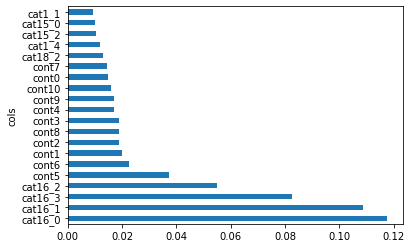

In [ ]:
fi = rf_feat_importance(m_emb, emb_xs)
fi[:20].plot('cols', 'imp', 'barh', legend=False);

In [ ]:
to_keep = fi[fi['imp']>.005].cols
len(to_keep)

28

Usually we experiment with the amount of columns to keep: we want as little features as possible without any meaningful drop in performance.

In [ ]:
xs_filt = emb_xs[to_keep]
valid_xs_filt = emb_valid_xs[to_keep]

In [ ]:
save_pickle('/content/valid_emb_filt', valid_xs_filt)
save_pickle('/content/train_emb_filt', xs_filt)

In [ ]:
# this cell will take a couple minutes
m_filt = rf(xs_filt, to.train.y, min_samples_leaf=10)
auc(m_filt, xs_filt, to.train.y), auc(m_filt, valid_xs_filt, to.valid.y)

(0.808, 0.764)

# <b> Conclusion

There are better replacements for one-hot encodings. Using embeddings from a trained neural network to represent categorical variables outperforms the one-hot encoding method in machine learning algorithms. Entity embeddings can represent categorical variables in a continuous way, retaining the relationship between different data values and thereby facilitating the model’s training. The better-performing machine learning models can be used in an ensemble or as a substitute for neural nets if requiring interpretability.


# <b> Inference

Let's apply our neural network and random forest that we trained to a test dataset in an ensemble.

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/tabular-playground-series-mar-2021/test.csv', low_memory=False)
test_df = test_df.drop('id', axis=1)
test_dl = dls.test_dl(test_df)
emb_test_xs = embed_features(learn, test_dl.dataset.xs)
filt_emb_test_xs = emb_test_xs[to_keep]

In [ ]:
save_pickle('/content/emb_test_filt', test_df)

In [ ]:
# NN inference
test_dl = dls.test_dl(test_df)
preds_nn,_ = learn.get_preds(dl=test_dl)
preds_nn = preds_nn.numpy().squeeze(1)
preds_nn

array([0.14901663, 0.38165867, 0.03072543, ..., 0.7112956 , 0.04985734,
       0.5394077 ], dtype=float32)

In [ ]:
# RF inference
preds_rf = m_filt.predict_proba(filt_emb_test_xs)[:,1]
preds_rf

array([0.13033737, 0.38531947, 0.18256122, ..., 0.55759311, 0.29970009,
       0.20999196])

In [ ]:
# simple ensemble
preds_ensemble = (preds_rf + preds_nn)/2
preds_ensemble

array([0.139677  , 0.38348907, 0.10664332, ..., 0.63444436, 0.17477871,
       0.37469981])

Here is a look from [paper](https://arxiv.org/pdf/1604.06737.pdf) that we implemented for tabular data showing that for entity embeddings we get the advatage with neural network:

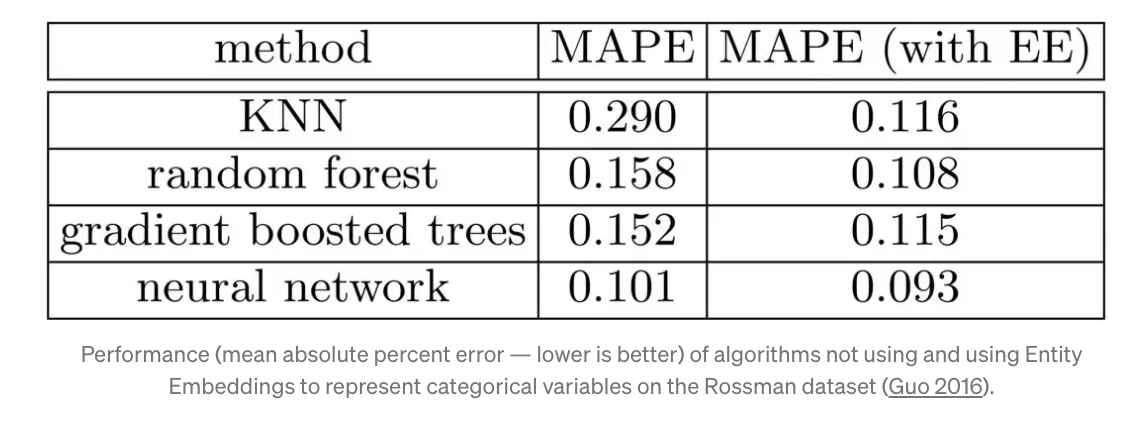

We obtained and learned about a more informative and flexible representation of categorical data that could help you in whatever you are planning to do with it!